In [2]:
%load_ext autoreload
%autoreload 2

### WLASL Data Validation and Model Checking

In [1]:
import os
import json

# define paths relative to the notebook
BASE_DIR = os.path.dirname(os.getcwd())  # goes one level up from /notebooks
DATA_DIR = os.path.join(BASE_DIR, "data", "video")

WLASL_JSON = os.path.join(DATA_DIR, "WLASL_v0.3.json")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
REBILT_JSON = os.path.join(DATA_DIR, "WLASL_rebuilt.json")

# load json
with open(WLASL_JSON, "r") as f:
    metadata = json.load(f)
MISSING_TXT = os.path.join(DATA_DIR, "missing_videos.txt")
ORIG_JSON = os.path.join(DATA_DIR, "WLASL_v0.3.json")


In [3]:
import os
import json
from tqdm import tqdm

# --- CONFIG ---
DATA_DIR = os.path.join(BASE_DIR, "data", "video")
VIDEO_DIR = os.path.join(DATA_DIR, "processed")   # or "transcoded" depending on what you want to check
JSON_PATH = os.path.join(DATA_DIR, "WLASL_v0.3.json")
MISSING_TXT = os.path.join(DATA_DIR, "missing_videos.txt")

# --- LOAD METADATA ---
with open(JSON_PATH, "r") as f:
    metadata = json.load(f)

# --- SCAN FOR MISSING FILES ---
missing_ids = []
total_instances = 0

for gloss_entry in tqdm(metadata, desc="Checking video files"):
    for inst in gloss_entry.get("instances", []):
        total_instances += 1
        vid_id = inst["video_id"]
        vid_path = os.path.join(VIDEO_DIR, f"{vid_id}.mp4")
        if not os.path.exists(vid_path):
            missing_ids.append(vid_id)

# --- WRITE MISSING IDS TO FILE ---
with open(MISSING_TXT, "w") as f:
    for vid_id in sorted(set(missing_ids)):
        f.write(f"{vid_id}\n")

print(f"Completed: {len(missing_ids)} missing out of {total_instances} total instances")
print(f"Saved missing IDs to: {MISSING_TXT}")


Checking video files: 100%|██████████| 2000/2000 [00:00<00:00, 17490.26it/s]

Completed: 8207 missing out of 21083 total instances
Saved missing IDs to: /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/video/missing_videos.txt


In [4]:
# --- load missing ids ---
with open(MISSING_TXT, "r") as f:
    missing_ids = set(line.strip() for line in f if line.strip())

print(f"Loaded {len(missing_ids)} missing video IDs")

# --- load original JSON ---
with open(ORIG_JSON, "r") as f:
    data = json.load(f)

print(f"Original entries: {len(data)} glosses")

# --- filter instances ---
rebuilt_data = []
removed_count = 0
for gloss_entry in data:
    valid_instances = []
    for inst in gloss_entry.get("instances", []):
        if inst["video_id"] not in missing_ids:
            valid_instances.append(inst)
        else:
            removed_count += 1
    if valid_instances:
        gloss_entry["instances"] = valid_instances
        rebuilt_data.append(gloss_entry)

print(f"Removed {removed_count} bad instances")
print(f"Remaining gloss entries: {len(rebuilt_data)}")


Loaded 8207 missing video IDs
Original entries: 2000 glosses
Removed 8207 bad instances
Remaining gloss entries: 1999


In [5]:
# --- save rebuilt file ---
with open(REBILT_JSON, "w") as f:
    json.dump(rebuilt_data, f, indent=2)

print(f"Rebuilt JSON saved to: {REBILT_JSON}")


Rebuilt JSON saved to: /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/video/WLASL_rebuilt.json


In [6]:
from collections import Counter
import json, os

rebuilt_path = os.path.join("/home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/video", "WLASL_rebuilt.json")

with open(rebuilt_path, "r") as f:
    rebuilt = json.load(f)

split_counter = Counter()
gloss_counter = {}

for g in rebuilt:
    gloss = g["gloss"]
    count = len(g["instances"])
    gloss_counter[gloss] = count
    for inst in g["instances"]:
        split = inst.get("split", "train")
        split_counter[split] += 1

print("Per split counts:", split_counter)
print("Total valid instances:", sum(split_counter.values()))
print("Average per gloss:", sum(gloss_counter.values()) / len(gloss_counter))


Per split counts: Counter({'train': 8328, 'val': 2564, 'test': 1984})
Total valid instances: 12876
Average per gloss: 6.441220610305153


In [7]:
rebuilt = [g for g in rebuilt if any(inst.get("split") == "train" for inst in g["instances"])]
print(f"Glosses with at least one train instance: {len(rebuilt)}")


Glosses with at least one train instance: 1998


In [8]:
from collections import Counter
import json, os

json_path = "../data/video/WLASL_rebuilt.json"

with open(json_path, "r") as f:
    data = json.load(f)

split_counts = Counter()
for gloss in data:
    for inst in gloss["instances"]:
        split_counts[inst.get("split", "train")] += 1

print("Split distribution:", split_counts)


Split distribution: Counter({'train': 8328, 'val': 2564, 'test': 1984})


In [17]:
gloss_counts = Counter({g["gloss"]: len(g["instances"]) for g in data})
gloss_df = pd.DataFrame(gloss_counts.items(), columns=["gloss", "count"]).sort_values("count", ascending=False)
print("Top 10 glosses:\n", gloss_df.head(10))

print("Glosses with ≤3 instances:", (gloss_df['count'] <= 3).sum())

Top 10 glosses:
            gloss  count
2       computer     20
1          drink     19
3         before     19
22           hot     16
23          like     16
17           yes     16
5             go     16
29  thanksgiving     15
46         shirt     15
7            who     15
Glosses with ≤3 instances: 95


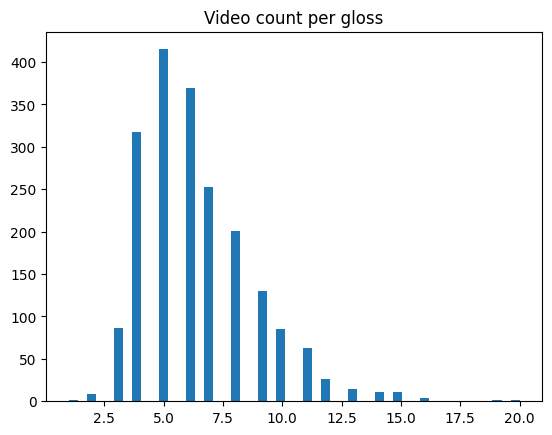

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

class_counts = Counter({g["gloss"]: len(g["instances"]) for g in data})
plt.hist(list(class_counts.values()), bins=50)
plt.title("Video count per gloss")
plt.show()


In [10]:
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_video_full(json_path, video_root, sample_size=None, plot=True):
    """
    Analyze all video stats: width, height, frame count, FPS.
    Optionally visualize all metrics together.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    all_videos = []
    for entry in data:
        for inst in entry["instances"]:
            vid_path = os.path.join(video_root, f"{inst['video_id']}.mp4")
            if os.path.exists(vid_path):
                all_videos.append(vid_path)

    if sample_size:
        all_videos = all_videos[:sample_size]

    widths, heights, frames, fps_list = [], [], [], []

    for vid in tqdm(all_videos, desc="Analyzing videos"):
        cap = cv2.VideoCapture(vid)
        if not cap.isOpened():
            continue
        widths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        heights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frames.append(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps_list.append(cap.get(cv2.CAP_PROP_FPS))
        cap.release()

    widths, heights, frames, fps_list = map(np.array, (widths, heights, frames, fps_list))

    # --- Print numeric summary ---
    print(f"{'Metric':<12} | {'Min':>8} | {'Mean':>8} | {'Max':>8}")
    print("-" * 45)
    print(f"{'Width':<12} | {widths.min():8.0f} | {widths.mean():8.0f} | {widths.max():8.0f}")
    print(f"{'Height':<12} | {heights.min():8.0f} | {heights.mean():8.0f} | {heights.max():8.0f}")
    print(f"{'Frames':<12} | {frames.min():8.0f} | {frames.mean():8.0f} | {frames.max():8.0f}")
    print(f"{'FPS':<12} | {fps_list.min():8.1f} | {fps_list.mean():8.1f} | {fps_list.max():8.1f}")

    # --- Plotting ---
    if plot:
        plt.figure(figsize=(16, 8))
        plt.suptitle("WLASL Video Statistics Overview", fontsize=16, weight='bold')

        # Histograms
        plt.subplot(2, 3, 1)
        plt.hist(widths, bins=40, color='skyblue')
        plt.title("Width Distribution"); plt.xlabel("Width (px)"); plt.ylabel("Count")

        plt.subplot(2, 3, 2)
        plt.hist(heights, bins=40, color='salmon')
        plt.title("Height Distribution"); plt.xlabel("Height (px)")

        plt.subplot(2, 3, 3)
        plt.hist(frames, bins=40, color='lightgreen')
        plt.title("Frame Count Distribution"); plt.xlabel("Frame count")

        plt.subplot(2, 3, 4)
        plt.hist(fps_list, bins=40, color='orange')
        plt.title("FPS Distribution"); plt.xlabel("FPS")

        # Scatter plots
        plt.subplot(2, 3, 5)
        plt.scatter(widths, heights, s=5, alpha=0.5, color='purple')
        plt.title("Width vs Height"); plt.xlabel("Width (px)"); plt.ylabel("Height (px)")

        plt.subplot(2, 3, 6)
        plt.scatter(frames, fps_list, s=5, alpha=0.5, color='teal')
        plt.title("Frame Count vs FPS"); plt.xlabel("Frames"); plt.ylabel("FPS")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return widths, heights, frames, fps_list


Analyzing videos: 100%|██████████| 12876/12876 [00:35<00:00, 366.85it/s] 


Metric       |      Min |     Mean |      Max
---------------------------------------------
Width        |      288 |      879 |     1920
Height       |      180 |      534 |     1080
Frames       |       15 |      911 |    12232
FPS          |     12.0 |     28.4 |     59.9


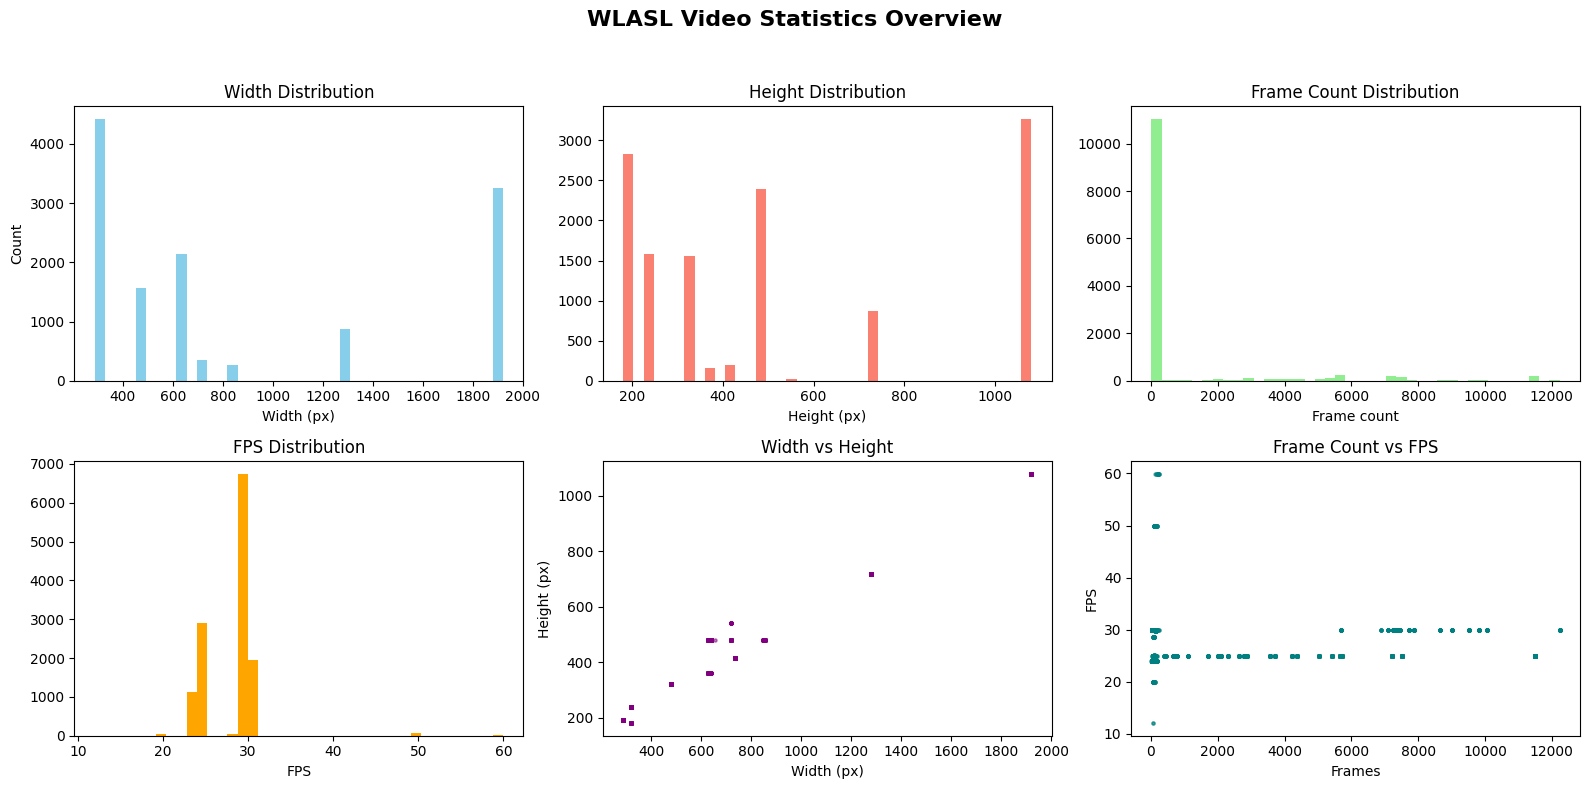

In [11]:
widths, heights, frames, fps_list = analyze_video_full(
    "../data/video/WLASL_rebuilt.json",
    "../data/video/processed",
)


Analyzing videos: 100%|██████████| 12876/12876 [00:46<00:00, 279.43it/s] 


Metric       |      Min |     Mean |      Max
---------------------------------------------
Width        |      426 |      426 |      426
Height       |      240 |      240 |      240
Frames       |       15 |       88 |      252
FPS          |     25.0 |     25.0 |     25.0


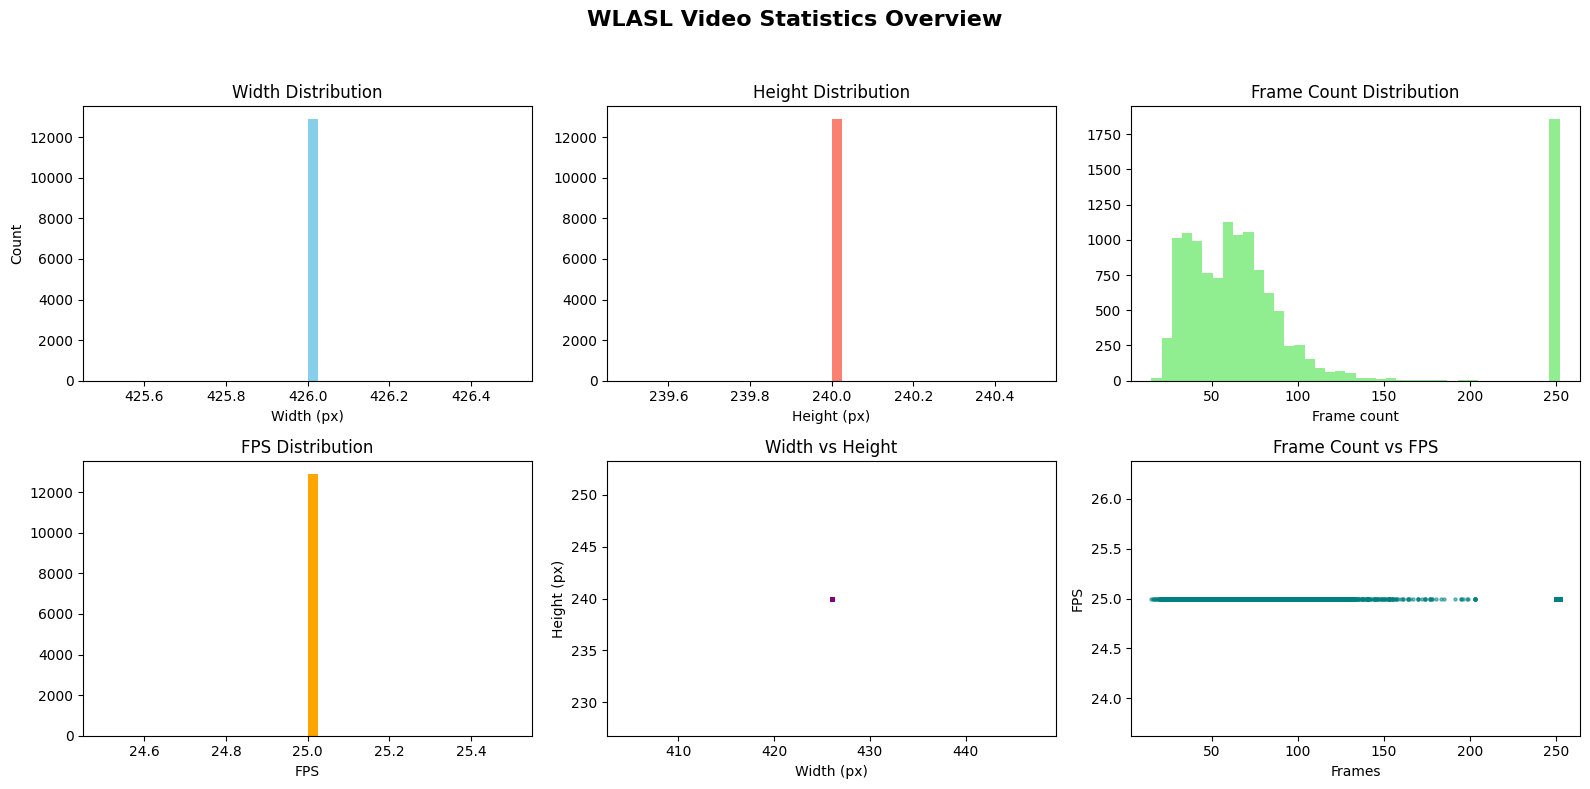

In [12]:
widths, heights, frames, fps_list = analyze_video_full(
    "../data/video/WLASL_rebuilt.json",
    "../data/video/transcoded",
)


In [13]:
from torchvision.io import read_video
frames, _, _ = read_video("../data/video/transcoded/63825.mp4", pts_unit="sec")
print(frames.shape)



torch.Size([53, 240, 426, 3])


/home/genesis/sem1_project/sign-to-speech-with-temporal-correction/env/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


In [14]:
import sys
sys.path.append("../src")

from wlasl_dataset_loader import WLASLDataset, pad_collate_fn
from torch.utils.data import DataLoader

ds = WLASLDataset(
    json_path="../data/video/WLASL_rebuilt.json",
    video_root="../data/video/transcoded",
    split="train"
)

sample = ds[0]
print("Sample shape:", sample["video"].shape)

from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=pad_collate_fn)
videos, labels = next(iter(dl))
print("Batch shape:", videos.shape)


[WLASL] Split=train | Videos=8328 | Classes≈1999
Sample shape: torch.Size([16, 3, 224, 224])
Batch shape: torch.Size([4, 3, 16, 224, 224])


In [15]:
from wlasl_dataset_loader import WLASLDataset

ds = WLASLDataset(
    json_path="../data/video/WLASL_rebuilt.json",
    video_root="../data/video/transcoded",
    split="train",
)

print(f"Samples: {len(ds)}")
sample = ds[0]
print(sample["video"].shape)

[WLASL] Split=train | Videos=8328 | Classes≈1999
Samples: 8328
torch.Size([16, 3, 224, 224])


In [18]:
from itertools import combinations

split_sets = {split: set() for split in ["train", "val", "test"]}
for g in data:
    for inst in g["instances"]:
        split_sets[inst.get("split", "train")].add(g["gloss"])

for (a, b) in combinations(split_sets, 2):
    overlap = split_sets[a].intersection(split_sets[b])
    print(f"Overlap between {a} and {b}: {len(overlap)} glosses")


Overlap between train and val: 1708 glosses
Overlap between train and test: 1535 glosses
Overlap between val and test: 1277 glosses


Analyzing processed: 100%|██████████| 1999/1999 [00:27<00:00, 71.41it/s] 


processed: 12876 valid / 12876 total (0 missing/unreadable)


Analyzing transcoded: 100%|██████████| 1999/1999 [00:40<00:00, 49.47it/s]


transcoded: 12876 valid / 12876 total (0 missing/unreadable)


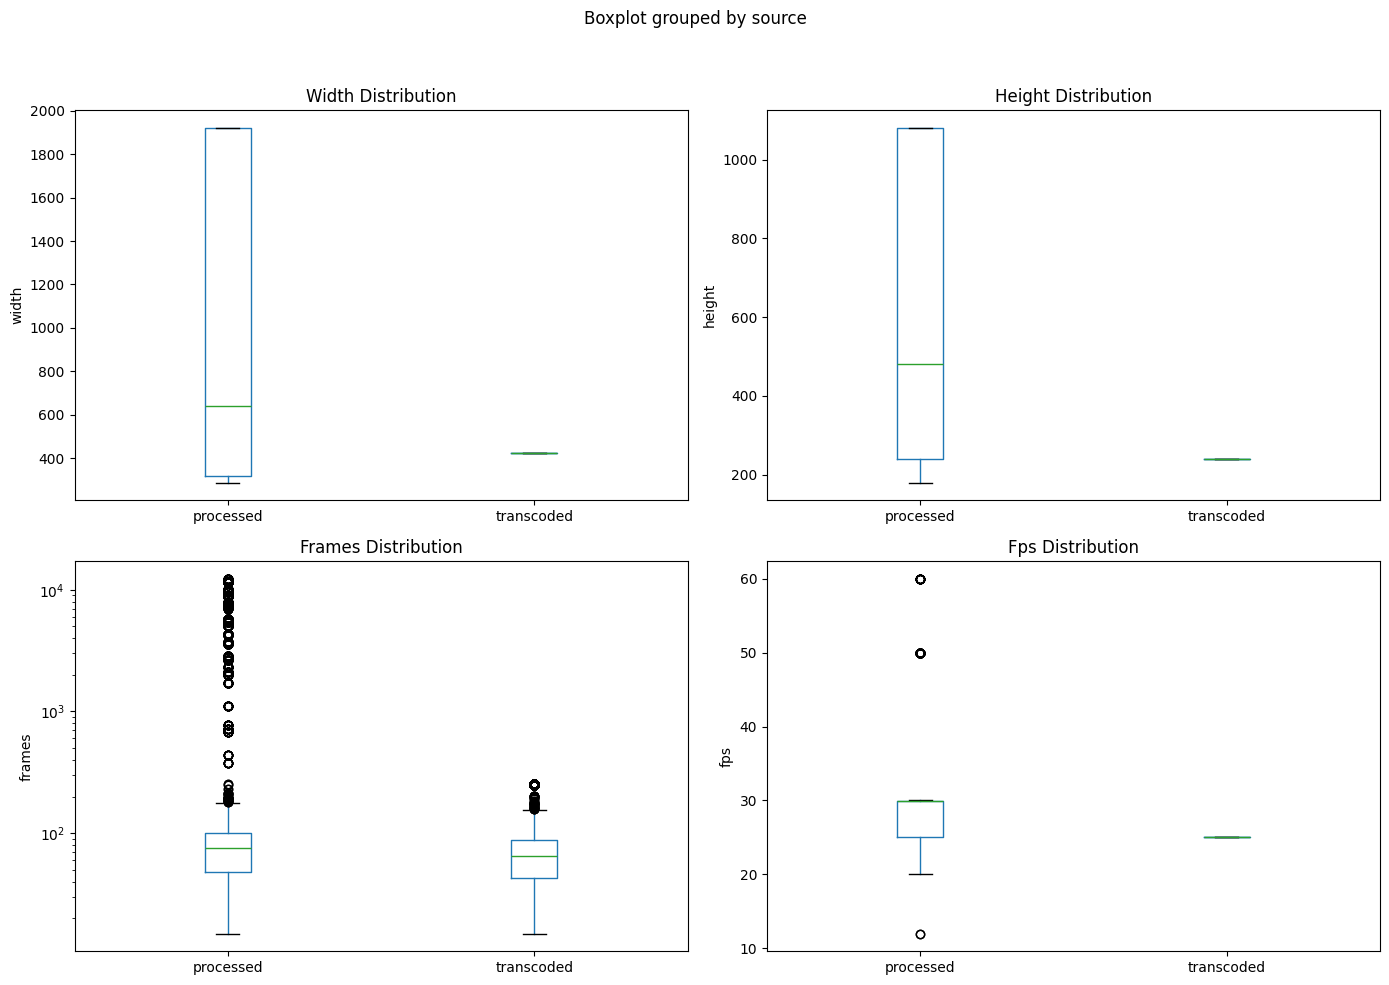

width                                height              \
                 mean         std    min     max       mean         std   
source                                                                    
processed   878.61137  655.600423  288.0  1920.0  533.59009  347.856265   
transcoded  426.00000    0.000000  426.0   426.0  240.00000    0.000000   

                               frames                                    fps  \
              min     max        mean          std   min      max       mean   
source                                                                         
processed   180.0  1080.0  910.606400  2350.889440  15.0  12232.0  28.423051   
transcoded  240.0   240.0   88.349099    70.275713  15.0    252.0  25.000000   

                                   
                 std   min    max  
source                             
processed   3.186757  12.0  59.94  
transcoded  0.000000  25.0  25.00

In [21]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIG ---
DATA_DIR = os.path.join(BASE_DIR, "data", "video")
JSON_PATH = os.path.join(DATA_DIR, "WLASL_stratified.json")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
TRANSCODED_DIR = os.path.join(DATA_DIR, "transcoded")

# --- LOAD METADATA ---
with open(JSON_PATH, "r") as f:
    data = json.load(f)

def collect_video_stats(video_dir, name="dataset"):
    """Collect width, height, frame count, and FPS for all videos."""
    widths, heights, frames, fps_list = [], [], [], []
    total, missing = 0, 0

    for entry in tqdm(data, desc=f"Analyzing {name}"):
        for inst in entry["instances"]:
            total += 1
            path = os.path.join(video_dir, f"{inst['video_id']}.mp4")
            if not os.path.exists(path):
                missing += 1
                continue

            cap = cv2.VideoCapture(path)
            if not cap.isOpened():
                missing += 1
                continue

            widths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            heights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frames.append(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps_list.append(cap.get(cv2.CAP_PROP_FPS))
            cap.release()

    df = pd.DataFrame({
        "width": widths,
        "height": heights,
        "frames": frames,
        "fps": fps_list,
        "source": name
    })

    print(f"{name}: {len(df)} valid / {total} total ({missing} missing/unreadable)")
    return df

# --- COLLECT STATS ---
processed_df = collect_video_stats(PROCESSED_DIR, "processed")
transcoded_df = collect_video_stats(TRANSCODED_DIR, "transcoded")

# --- COMBINE AND COMPARE ---
combined = pd.concat([processed_df, transcoded_df], ignore_index=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Processed vs Transcoded Video Comparison", fontsize=16, weight="bold")

for i, col in enumerate(["width", "height", "frames", "fps"]):
    ax = axes[i//2, i%2]
    combined.boxplot(column=col, by="source", ax=ax, grid=False)
    ax.set_title(f"{col.capitalize()} Distribution")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.set_yscale('log' if col in ["frames"] else 'linear')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- SUMMARY TABLE ---
summary = combined.groupby("source")[["width", "height", "frames", "fps"]].agg(["mean", "std", "min", "max"])
display(summary)
